<a href="https://colab.research.google.com/github/suleymanerpak/Movie-Recommendation-Systems/blob/main/Movie_Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli kütüphaneler
import pandas as pd

# CSV dosyalarını oku
from google.colab import drive
drive.mount('/content/drive')

movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tags.csv')
links = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/links.csv')


# İlk birkaç satırı görelim
print("🎬 Movies:")
print(movies.head())

print("\n⭐ Ratings:")
print(ratings.head())

print("\n🏷️ Tags:")
print(tags.head())

print("\n🔗 Links:")
print(links.head())

Mounted at /content/drive
🎬 Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

⭐ Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

🏷️ Tags:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Hig

In [ ]:
# Adım 1: Aynı filmId'ye ait tüm tag'leri birleştir (tek satıra)
tag_df = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Adım 2: movies verisi ile tag'leri birleştir
movies_merged = pd.merge(movies, tag_df, on='movieId', how='left')

# Adım 3: NaN tag’leri boş string yap
movies_merged['tag'] = movies_merged['tag'].fillna('')

# Adım 4: genres ve tag’leri birleştir
movies_merged['content'] = movies_merged['genres'] + ' ' + movies_merged['tag']

# Kontrol: İlk 5 içeriğe bakalım
print(movies_merged[['title', 'content']].head())

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                             content  
0  Adventure|Animation|Children|Comedy|Fantasy pi...  
1  Adventure|Children|Fantasy fantasy magic board...  
2                           Comedy|Romance moldy old  
3                              Comedy|Drama|Romance   
4                            Comedy pregnancy remake  


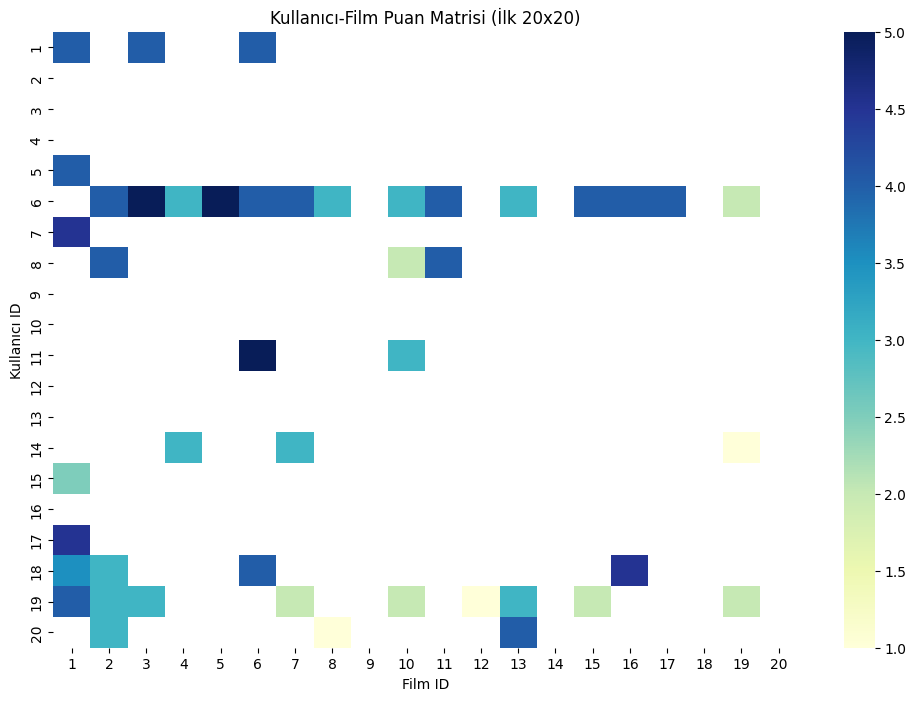

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ratings.csv dosyasını oku
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ratings.csv")

# Kullanıcı-Film puan matrisini oluştur
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Küçük bir örnek matris oluşturalım
sample_matrix = user_movie_matrix.iloc[:20, :20]

plt.figure(figsize=(12,8))
sns.heatmap(sample_matrix, cmap='YlGnBu', cbar=True)
plt.title("Kullanıcı-Film Puan Matrisi (İlk 20x20)")
plt.xlabel("Film ID")
plt.ylabel("Kullanıcı ID")
plt.show()

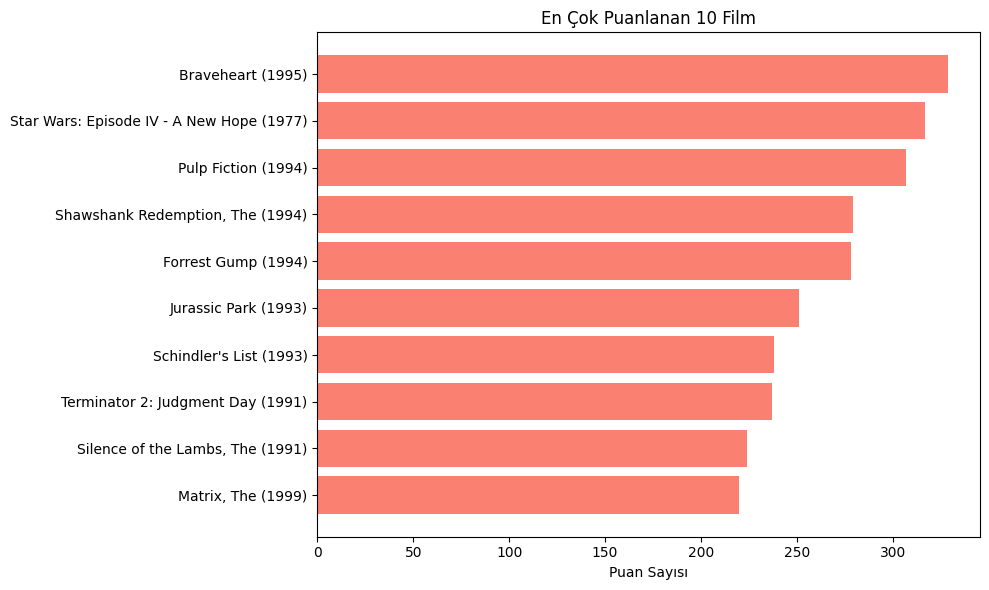

In [ ]:
en_cok_puanlanan = ratings['movieId'].value_counts().head(10)
en_cok_filmler = movies[movies['movieId'].isin(en_cok_puanlanan.index)]

plt.figure(figsize=(10,6))
plt.barh(en_cok_filmler['title'], en_cok_puanlanan.values, color='salmon')
plt.xlabel("Puan Sayısı")
plt.title("En Çok Puanlanan 10 Film")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirici
tfidf = TfidfVectorizer(stop_words='english')  # İngilizce stop word'leri çıkar

# content sütununu vektöre çevir
tfidf_matrix = tfidf.fit_transform(movies_merged['content'])

# Kontrol: matrisin boyutu
print("TF-IDF matris boyutu:", tfidf_matrix.shape)

TF-IDF matris boyutu: (9742, 1677)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF matrisinden cosine similarity matrisi hesapla
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Kontrol: benzerlik matrisinin boyutu
print("Benzerlik matris boyutu:", cosine_sim.shape)


Benzerlik matris boyutu: (9742, 9742)


In [ ]:
# 🎬 Gerekli kütüphaneler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# 📌 Kullanıcıdan film adı al – boşluk ve - karakterlerini kaldırarak normalize et
film_adi = input("🎬 Lütfen bir film adı girin (örneğin: Matrix): ").lower().strip().replace(" ", "").replace("-", "")

# 🔍 Filmlerdeki başlıkları da normalize et
movies_merged['normalized_title'] = movies_merged['title'].str.lower().str.replace(" ", "").str.replace("-", "")

# 🔍 Eşleşen film araması (daha toleranslı)
eslesen = movies_merged[movies_merged['normalized_title'].str.contains(film_adi, regex=False)]

# 🎯 Eşleşme yoksa uyarı ver
if eslesen.empty:
    print("⚠️ Film bulunamadı:", film_adi)
else:
    # 🎥 Eşleşen film başlıklarını yazdır
    print("\n🔍 Eşleşen filmler:")
    print(eslesen['title'].head(5).to_string(index=False))

    # İlk eşleşeni al
    film_index = eslesen.index[0]

    # ✅ Cosine similarity ile benzerlik skorlarını al
    benzerlik_skorlari = list(enumerate(cosine_sim[film_index]))
    benzerlik_skorlari = sorted(benzerlik_skorlari, key=lambda x: x[1], reverse=True)

    # 🧠 En benzer 10 filmi yazdır (kendisi hariç)
    print(f"\n🎯 '{eslesen.iloc[0]['title']}' filmine en benzer filmler:\n")
    for i, (idx, skor) in enumerate(benzerlik_skorlari[1:11], start=1):
        benzer_film = movies_merged.iloc[idx]['title']
        print(f"{i}. {benzer_film}  (Benzerlik skoru: {skor:.2f})")

🎬 Lütfen bir film adı girin (örneğin: Matrix): matrix

🔍 Eşleşen filmler:
            Matrix, The (1999)
   Matrix Reloaded, The (2003)
Matrix Revolutions, The (2003)
         Animatrix, The (2003)

🎯 'Matrix, The (1999)' filmine en benzer filmler:

1. Jetée, La (1962)  (Benzerlik skoru: 0.57)
2. Sliding Doors (1998)  (Benzerlik skoru: 0.49)
3. House of Flying Daggers (Shi mian mai fu) (2004)  (Benzerlik skoru: 0.47)
4. Karate Kid, The (1984)  (Benzerlik skoru: 0.47)
5. Karate Kid, Part II, The (1986)  (Benzerlik skoru: 0.46)
6. Hero (Ying xiong) (2002)  (Benzerlik skoru: 0.46)
7. Karate Kid, Part III, The (1989)  (Benzerlik skoru: 0.44)
8. Kill Bill: Vol. 1 (2003)  (Benzerlik skoru: 0.41)
9. Postman, The (1997)  (Benzerlik skoru: 0.40)
10. Lawnmower Man 2: Beyond Cyberspace (1996)  (Benzerlik skoru: 0.40)


In [ ]:
import plotly.graph_objects as go

# 🎬 Kullanıcıdan film al
film_adi = input("🎬 Görselleştirme için bir film adı girin (örneğin: Matrix): ").lower().strip()

# 🔧 Normalize işlemi: boşluk ve tire kaldır
film_adi = film_adi.replace(" ", "").replace("-", "")

# Filmler için de normalize edilmiş başlık oluşturalım
movies_merged['normalized_title'] = movies_merged['title'].str.replace(" ", "").str.replace("-", "").str.lower()

# 🔍 Eşleşen film araması
eslesen = movies_merged[movies_merged['normalized_title'].str.contains(film_adi, regex=False)]

# 🔍 Eşleşen film başlıklarını her durumda göster
print("\n🔍 Eşleşen film başlıkları:")
if eslesen.empty:
    print("⚠️ Film bulunamadı:", film_adi)
else:
    print(eslesen['title'].head(10).to_string(index=False))

    # İlk eşleşeni kullanalım (en üstteki)
    film_index = eslesen.index[0]

    # 🎯 Benzerlik skorlarını sırala
    benzerlik_skorlari = list(enumerate(cosine_sim[film_index]))
    benzerlik_skorlari = sorted(benzerlik_skorlari, key=lambda x: x[1], reverse=True)
    benzer_film_indexleri = [i[0] for i in benzerlik_skorlari[1:11]]
    benzerlik_degerleri = [i[1] for i in benzerlik_skorlari[1:11]]
    benzer_film_isimleri = [movies_merged.iloc[i]['title'] for i in benzer_film_indexleri]

    # 📊 Etkileşimli bar chart oluştur
    fig = go.Figure(go.Bar(
        x=benzerlik_degerleri[::-1],
        y=benzer_film_isimleri[::-1],
        orientation='h',
        marker=dict(color='lightseagreen'),
        hovertext=[f"Benzerlik skoru: {skor:.2f}" for skor in benzerlik_degerleri[::-1]]
    ))

    fig.update_layout(
        title=f"🎬 '{eslesen.iloc[0]['title']}' Filmine Benzer Öneriler",
        xaxis_title="Benzerlik Skoru",
        yaxis_title="Film Adı",
        height=600
    )

    fig.show()


🎬 Görselleştirme için bir film adı girin (örneğin: Matrix): matrix

🔍 Eşleşen film başlıkları:
            Matrix, The (1999)
   Matrix Reloaded, The (2003)
Matrix Revolutions, The (2003)
         Animatrix, The (2003)


🎬 Spider Chart için bir film adı girin (örneğin: Matrix): spider man

🔍 Eşleşen film başlıkları:
                Spider-Man (2002)
              Spider-Man 2 (2004)
              Spider-Man 3 (2007)
   Amazing Spider-Man, The (2012)
  The Amazing Spider-Man 2 (2014)
Untitled Spider-Man Reboot (2017)


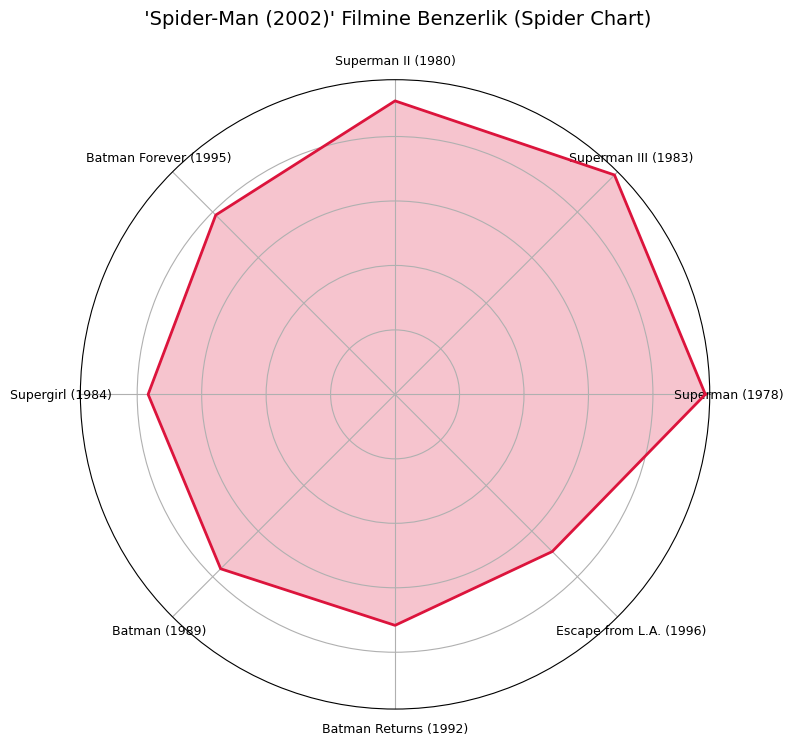

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 🎬 Kullanıcıdan film al
film_adi = input("🎬 Spider Chart için bir film adı girin (örneğin: Matrix): ").lower().strip()

# Normalize: boşluk ve tire sil, küçük harfe çevir
film_adi = film_adi.replace(" ", "").replace("-", "")
movies_merged['normalized_title'] = movies_merged['title'].str.replace(" ", "").str.replace("-", "").str.lower()

# 🔍 Eşleşen film araması
eslesen = movies_merged[movies_merged['normalized_title'].str.contains(film_adi, regex=False)]

# Eşleşenleri göster
print("\n🔍 Eşleşen film başlıkları:")
if eslesen.empty:
    print("⚠️ Film bulunamadı:", film_adi)
else:
    print(eslesen['title'].head(10).to_string(index=False))

    # İlk eşleşeni al
    film_index = eslesen.index[0]

    # Benzerlik skorlarını al
    benzerlik_skorlari = list(enumerate(cosine_sim[film_index]))
    benzerlik_skorlari = sorted(benzerlik_skorlari, key=lambda x: x[1], reverse=True)

    # İlk 8 benzer filmi al (kendisi hariç)
    benzer_film_indexleri = [i[0] for i in benzerlik_skorlari[1:9]]
    benzerlik_degerleri = [i[1] for i in benzerlik_skorlari[1:9]]
    benzer_film_isimleri = [movies_merged.iloc[i]['title'] for i in benzer_film_indexleri]

    # SPIDER CHART ÇİZİMİ
    angles = np.linspace(0, 2 * np.pi, len(benzer_film_isimleri), endpoint=False).tolist()
    scores = benzerlik_degerleri + [benzerlik_degerleri[0]]  # ilkini sona ekle
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, scores, color='crimson', linewidth=2)
    ax.fill(angles, scores, color='crimson', alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(benzer_film_isimleri, fontsize=9)
    ax.set_yticklabels([])

plt.title(f" '{eslesen.iloc[0]['title']}' Filmine Benzerlik (Spider Chart)", size=14, pad=40)
plt.tight_layout()
plt.show()

In [ ]:
# Gerekli kütüphane
import pandas as pd

# Kullanıcı-Film matrisi: her hücre rating olacak
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Kontrol: boyut ve ilk birkaç satır
print("Kullanıcı-Film Puan Matrisi boyutu:", user_movie_matrix.shape)
print(user_movie_matrix.head())

Kullanıcı-Film Puan Matrisi boyutu: (610, 9724)
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  .

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Puan matrisinin transpozunu al: satırlar filmler, sütunlar kullanıcılar olacak
movie_user_matrix = user_movie_matrix.T

# Cosine similarity ile film-film benzerlik matrisi hesapla
movie_similarity = cosine_similarity(movie_user_matrix.fillna(0))

# Sonucu DataFrame olarak kaydedelim (filmlerin ID'leriyle eşleşsin)
movie_similarity_df = pd.DataFrame(movie_similarity, index=movie_user_matrix.index, columns=movie_user_matrix.index)

# Kontrol: boyut ve örnek benzerlikler
print("Film-Film Benzerlik Matrisi boyutu:", movie_similarity_df.shape)
print("\n🎬 Toy Story (movieId=1) ile en benzer filmler:")
print(movie_similarity_df[1].sort_values(ascending=False).head(10))

Film-Film Benzerlik Matrisi boyutu: (9724, 9724)

🎬 Toy Story (movieId=1) ile en benzer filmler:
movieId
1       1.000000
3114    0.572601
480     0.565637
780     0.564262
260     0.557388
356     0.547096
364     0.541145
1210    0.541089
648     0.538913
1265    0.534169
Name: 1, dtype: float64


In [ ]:
def onerilen_filmler_kullanicidan(top_n=10):
    try:
        movie_id = int(input("🎬 Lütfen bir film ID'si (movieId) girin: "))
    except ValueError:
        print("❌ Geçerli bir sayı girilmedi.")
        return

    if movie_id not in movie_similarity_df.columns:
        print("❌ Bu movieId veri setinde yok.")
        return

    benzer_filmler = movie_similarity_df[movie_id].sort_values(ascending=False).iloc[1:top_n+1]

    # Film adını getir
    film_adi = movies[movies['movieId'] == movie_id]['title'].values
    film_adi = film_adi[0] if len(film_adi) > 0 else "Bilinmeyen Film"

    print(f"\n🎬 {film_adi} (movieId={movie_id}) filmine en benzer {top_n} film:")

    for film_id, skor in benzer_filmler.items():
        film_adi = movies[movies['movieId'] == film_id]['title'].values
        if len(film_adi) > 0:
            print(f"{film_adi[0]} (Benzerlik: {skor:.2f})")
        else:
            print(f"movieId={film_id} (Başlık bulunamadı) (Benzerlik: {skor:.2f})")

# 📌 Örnek kullanım
onerilen_filmler_kullanicidan()

🎬 Lütfen bir film ID'si (movieId) girin: 54

🎬 Big Green, The (1995) (movieId=54) filmine en benzer 10 film:
Poison Ivy II (1996) (Benzerlik: 0.95)
Jefferson in Paris (1995) (Benzerlik: 0.87)
Gordy (1995) (Benzerlik: 0.87)
Poetic Justice (1993) (Benzerlik: 0.87)
Three Wishes (1995) (Benzerlik: 0.87)
I Like It Like That (1994) (Benzerlik: 0.87)
Walking Dead, The (1995) (Benzerlik: 0.87)
Reckless (1995) (Benzerlik: 0.87)
Rent-a-Kid (1995) (Benzerlik: 0.87)
Cure, The (1995) (Benzerlik: 0.87)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Hiperparametre aralıklarını tanımla
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # L1 cezası için bu solver gerekli
}

# Model nesnesini oluştur
log_reg = LogisticRegression(max_iter=1000)

# GridSearchCV kullan
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Modeli eğit (X_train, y_train senin eğitim verin)
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve doğruluğu yazdır
print("✅ En iyi doğruluk (cross-validation):", grid_search.best_score_)
print("🔧 En iyi parametreler:", grid_search.best_params_)

# En iyi model ile test setini değerlendir
from sklearn.metrics import classification_report, accuracy_score

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("📊 Test Seti Doğruluğu:", accuracy_score(y_test, y_pred))
print("\n🧾 Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ En iyi doğruluk (cross-validation): 0.5720359415359699
🔧 En iyi parametreler: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
📊 Test Seti Doğruluğu: 0.5725902419674732

🧾 Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.58      0.68      0.62     10477
           1       0.57      0.46      0.51      9691

    accuracy                           0.57     20168
   macro avg       0.57      0.57      0.57     20168
weighted avg       0.57      0.57      0.57     20168



In [ ]:
# 🎬 Kullanıcıdan film adı al
film_adi = input("🎬 Beğeni tahmini için bir film adı girin: ").lower().strip().replace(" ", "").replace("-", "")

# 🎯 Filmlerin normalize edilmiş başlık sütununu oluştur
movies_merged['normalized_title'] = (
    movies_merged['title']
    .str.lower()
    .str.replace(" ", "", regex=False)
    .str.replace("-", "", regex=False)
)

# 🔍 Normalize edilmiş başlıkta ara
eslesen = movies_merged[movies_merged['normalized_title'].str.contains(film_adi, regex=False)]

# ⚠️ Eşleşme kontrolü
if eslesen.empty:
    print("❌ Film bulunamadı:", film_adi)
else:
    print("\n🔍 Eşleşen film başlıkları:")
    print(eslesen['title'].head(1).to_string(index=False))

    secilen_film = eslesen.iloc[0]
    film_id = secilen_film['movieId']

    # film_vektörü hazırlanıyor
    film_index = movies_merged[movies_merged['movieId'] == film_id].index[0]
    film_vektor = X.iloc[[film_index]]  # X: genre one-hot encoded

    # 🎯 Tahmin (örnek: lojistik regresyon ile)
    tahmin = best_model.predict(film_vektor)[0]
    olasilik = best_model.predict_proba(film_vektor)[0][tahmin]

    if tahmin == 1:
        print(f"\n👍 '{secilen_film['title']}' filmi büyük olasılıkla BEĞENİLECEK (%{olasilik*100:.1f})")
    else:
        print(f"\n👎 '{secilen_film['title']}' filmi büyük olasılıkla BEĞENİLMEYECEK (%{olasilik*100:.1f})")

🎬 Beğeni tahmini için bir film adı girin: lord of the rings

🔍 Eşleşen film başlıkları:
Lord of the Rings, The (1978)

👍 'Lord of the Rings, The (1978)' filmi büyük olasılıkla BEĞENİLECEK (%55.6)


In [ ]:
import plotly.graph_objects as go

# Örnek veri
film_adi = "Spider-Man (2002)"
olasilik = 0.504  # %50.4 olarak tahmin

# Gauge chart
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=olasilik * 100,
    title={'text': f"🎯 '{film_adi}' için Beğeni Tahmini"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "green" if olasilik >= 0.5 else "red"},
        'steps': [
            {'range': [0, 50], 'color': 'lightcoral'},
            {'range': [50, 100], 'color': 'lightgreen'}
        ],
    }
))

fig.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Veri setlerini oku
movies = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ratings.csv")

# 2. Türleri one-hot encode et
movies_features = movies['genres'].str.get_dummies(sep='|')

# 3. Her film için ortalama puanı al
film_ortalama_puan = ratings.groupby('movieId')['rating'].mean()

# 4. Ortalamaya göre 1 (beğenildi) / 0 (beğenilmedi) etiketi ver
y = film_ortalama_puan.apply(lambda x: 1 if x >= 3.5 else 0)

# 5. Ortak filmId’leri al
ortak_idler = movies['movieId'][movies['movieId'].isin(y.index)]

# 6. X ve y’yi hizala
X = movies_features[movies['movieId'].isin(ortak_idler)].reset_index(drop=True)
y = y.loc[ortak_idler].reset_index(drop=True)

# 7. Eğitim/Test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 8. KNN modeli
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

# 9. Tahmin ve değerlendirme
y_pred = knn.predict(X_test)
print("🔍 KNN Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧾 Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

🔍 KNN Accuracy: 0.6031528444139822

🧾 Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63      1528
           1       0.59      0.54      0.57      1390

    accuracy                           0.60      2918
   macro avg       0.60      0.60      0.60      2918
weighted avg       0.60      0.60      0.60      2918



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 🎯 Tahmin modeli: KNN
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

# 🔍 Kullanıcıdan film adı al
film_adi = input("🎬 Beğeni tahmini için bir film adı girin: ").lower().strip()

# Eşleşen filmleri bul
eslesen = movies[movies['title'].str.lower().str.contains(film_adi)]

if eslesen.empty:
    print("❌ Film bulunamadı:", film_adi)
else:
    print("\n🔍 Eşleşen film başlıkları:")
    print(eslesen['title'].head(5).to_string(index=False))

    secilen_film = eslesen.iloc[0]  # İlk eşleşen film
    film_id = secilen_film['movieId']

    # Bu film için özellikleri bul
    film_index = movies[movies['movieId'] == film_id].index[0]
    ozellik = X.iloc[[film_index]]  # Hem DataFrame olarak kalır hem feature names korunur

    # Beğenilme tahmini
    tahmin = knn.predict(ozellik)[0]
    olasilik = knn.predict_proba(ozellik)[0][tahmin]

    if tahmin == 1:
        print(f"\n👍 '{secilen_film['title']}' filmi büyük olasılıkla BEĞENİLECEK (%{olasilik*100:.1f})")
    else:
        print(f"\n👎 '{secilen_film['title']}' filmi büyük olasılıkla BEĞENİLMEYECEK (%{olasilik*100:.1f})")

    # Alternatif olarak en benzer filmleri de gösterebilirsin
    print("\n🎯 Türüne göre benzer filmlerden bazıları:")
    benzer_filmler = X.dot(X.iloc[film_index])  # basit dot product
    benzer_filmler = benzer_filmler.sort_values(ascending=False).head(6).index[1:]

    for idx in benzer_filmler:
        print("-", movies.iloc[idx]['title'])

🎬 Beğeni tahmini için bir film adı girin: toy story

🔍 Eşleşen film başlıkları:
  Toy Story (1995)
Toy Story 2 (1999)
Toy Story 3 (2010)

👎 'Toy Story (1995)' filmi büyük olasılıkla BEĞENİLMEYECEK (%54.5)

🎯 Türüne göre benzer filmlerden bazıları:
- 5 Centimeters per Second (Byôsoku 5 senchimêtoru) (2007)
- Please Give (2010)
- Blue Valentine (2010)
- American Gangster (2007)
- Down Argentine Way (1940)


In [ ]:
import plotly.graph_objects as go

# Beğeni tahmini olasılığı
oran = knn.predict_proba(ozellik)[0][1] * 100

# Gauge chart oluştur
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=oran,
    title={'text': f"🎯 Beğeni Tahmini: {secilen_film['title']}"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': "green" if oran >= 50 else "red"},
        'steps': [
            {'range': [0, 50], 'color': 'lightcoral'},
            {'range': [50, 100], 'color': 'lightgreen'}
        ],
    }
))

fig.show()